<a href="https://colab.research.google.com/github/TadaoYamaoka/ShogiAIBook2/blob/main/notebook/python-dlshogi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythonで将棋AIを作る

## ランタイムのタイプの確認
メニューの「ランタイム」－「ランタイムのタイプを変更」から、 「ハードウェア アクセラレータ」が「GPU」になっていることを確認する。

## CUDAバージョンの確認

In [1]:
!nvidia-smi

Sun Oct 10 06:29:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 将棋ライブラリcshogi

### インストール

In [2]:
!pip install cshogi

     |████████████████████████████████| 3.8 MB 5.5 MB/s 


### パッケージインポート

In [ ]:
import cshogi

### 盤面作成

In [ ]:
board = cshogi.Board()

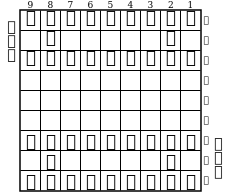

In [ ]:
board

### 合法手生成

In [ ]:
for move in board.legal_moves:
     print(cshogi.move_to_usi(move))

1g1f
2g2f
3g3f
4g4f
5g5f
6g6f
7g7f
8g8f
9g9f
1i1h
9i9h
3i3h
3i4h
7i6h
7i7h
2h1h
2h3h
2h4h
2h5h
2h6h
2h7h
4i3h
4i4h
4i5h
6i5h
6i6h
6i7h
5i4h
5i5h
5i6h


### 手を指す

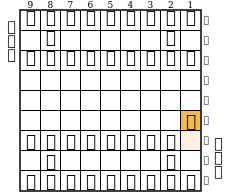

In [ ]:
# 合法手生成の1番目の手を指す
move = list(board.legal_moves)[0]
board.push(move)
board

73275


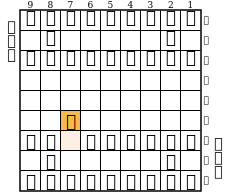

In [ ]:
# 指し手にUSIプロトコルの文字列を使う場合
board = cshogi.Board()
move = board.move_from_usi('7g7f')
print(move)
board.push(move)
board

73275


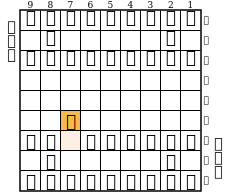

In [ ]:
# USIプロトコルの文字列を直接使う
board = cshogi.Board()
move = board.push_usi('7g7f')
print(move)
board

### 手を戻す

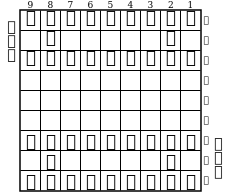

In [ ]:
board.pop()
board

## ソースコードとモジュールインストール

In [4]:
# ソースコードのクローン
!git clone https://github.com/TadaoYamaoka/python-dlshogi2.git

Cloning into 'python-dlshogi2'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 158 (delta 83), reused 110 (delta 39), pack-reused 0
Receiving objects: 100% (158/158), 156.92 MiB | 30.15 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (23/23), done.


In [5]:
# パッケージインストール
%cd python-dlshogi2
!pip install -e .

/content/python-dlshogi2
Obtaining file:///content/python-dlshogi2
  Running setup.py develop for python-dlshogi2


## モデルの学習

### 訓練データの準備

#### floodgateの棋譜

In [ ]:
# ダウンロード
%cd /content
!mkdir floodgate
%cd floodgate
!wget http://wdoor.c.u-tokyo.ac.jp/shogi/x/wdoor2020.7z

/content
/content/floodgate
--2021-09-28 13:21:00--  http://wdoor.c.u-tokyo.ac.jp/shogi/x/wdoor2020.7z
Resolving wdoor.c.u-tokyo.ac.jp (wdoor.c.u-tokyo.ac.jp)... 157.82.29.44
Connecting to wdoor.c.u-tokyo.ac.jp (wdoor.c.u-tokyo.ac.jp)|157.82.29.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353649671 (337M) [application/x-7z-compressed]
Saving to: ‘wdoor2020.7z’

wdoor2020.7z        100%[===================>] 337.27M  21.9MB/s    in 17s     

2021-09-28 13:21:17 (20.4 MB/s) - ‘wdoor2020.7z’ saved [353649671/353649671]



In [ ]:
# 2020年1月分を解凍
!7z x wdoor2020.7z 2020/*202001*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2071 . 2020/wdoor+floodgate-300-10F+3 . 020_GTX1060+20200523030007.csa                                                                     

In [ ]:
# 2020年2月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202002*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年3月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202003*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               3% 2071 . 2020/wdoor+floodgate-300-10F+3 . 020_GTX1060+20200523030007.csa                                                                     

In [ ]:
# 2020年4月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202004*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               3% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年5月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202005*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 960 . 2020/wdoor+floodgate-300-10F+2 . _w909_n_2400+20200311183012.csa                                                                             1% 2208 . 2020/wdoor+floodgate-300-10F+32x+Yss1000k+20201206233005.csa                                                                        

In [ ]:
# 2020年6月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202006*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 1168 . 2020/wdoor+floodgate-300-10F+22 . _473stb_100k+20200317113003.csa                                                                               1% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年7月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202007*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年8月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202008*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 1168 . 2020/wdoor+floodgate-300-10F+22 . _473stb_100k+20200317113003.csa                                                                               2% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年9月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202009*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 29 - 2020/wdoor+floodgate-300-10F+10W+Kamuy_vi05_1c+20200918070005.csa                                                                             0% 53 - 2020/wdoor+floodgate-300-10F+1 . tb_16t_100m+20200925070003.csa                                                                         

In [ ]:
# 2020年10月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202010*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2513 . 2020/wdoor+floodgate-300-10F+ . 10_i9-7920x+20201211110014.csa                                                                       

In [ ]:
# 2020年11月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202011*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2306 . 2020/wdoor+floodgate-300-10F+40b2_1011+Yss1000k+20201013003007.csa                                                               

In [ ]:
# 2020年12月分を解凍
!7z -aoa x wdoor2020.7z 2020/*202012*.csa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 353649671 bytes (338 MiB)

Extracting archive: wdoor2020.7z
--
Path = wdoor2020.7z
Type = 7z
Physical Size = 353649671
Headers Size = 2164031
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 932 . 2020/wdoor+floodgate-300-10F+22 . 904_n_p400_t8+20200310210011.csa                                                                               1% 2259 - 2020/wdoor+floodgate-300-10F . 479_4t_10m+20201202020013.csa                                                                        

#### CSA形式の棋譜からhcpe形式に変換

In [ ]:
%cd /content/python-dlshogi2
!python utils/csa_to_hcpe.py /content/floodgate train.hcpe test.hcpe

/content/python-dlshogi2
kif_num 4268
position_num 642164
kif_num 429
position_num 63490


### 訓練の実行

In [ ]:
!python pydlshogi2/train.py train.hcpe test.hcpe

2021/09/28 13:30:09	INFO	batchsize=1024
2021/09/28 13:30:09	INFO	lr=0.01
2021/09/28 13:30:18	INFO	Reading training data
2021/09/28 13:30:18	INFO	train.hcpe
2021/09/28 13:30:18	INFO	Reading test data
2021/09/28 13:30:18	INFO	test.hcpe
2021/09/28 13:30:18	INFO	train position num = 642164
2021/09/28 13:30:18	INFO	test position num = 63490
2021/09/28 13:32:59	INFO	epoch = 1, steps = 100, train loss = 5.2249446, 0.6670204, 5.8919650, test loss = 4.2034826, 0.6680851, 4.8715677, test accuracy = 0.1962891, 0.5595703
2021/09/28 13:35:42	INFO	epoch = 1, steps = 200, train loss = 3.8561930, 0.6532220, 4.5094151, test loss = 3.4765415, 0.6575505, 4.1340920, test accuracy = 0.2246094, 0.5888672
2021/09/28 13:38:25	INFO	epoch = 1, steps = 300, train loss = 3.4307636, 0.6391758, 4.0699394, test loss = 3.2145069, 0.6489418, 3.8634486, test accuracy = 0.2460938, 0.5917969
2021/09/28 13:41:08	INFO	epoch = 1, steps = 400, train loss = 3.2253957, 0.6291467, 3.8545425, test loss = 3.1166303, 0.6437407, 3.

In [ ]:
# チェックポイントが保存されていることを確認
!ls -l checkpoints

total 115764
-rw-r--r-- 1 root root 59268189 Sep 28 13:47 checkpoint-001.pth
-rw-r--r-- 1 root root 59273023 Sep 28 13:20 checkpoint.pth


#### チェックポイントをローカルにダウンロード

In [ ]:
# zipで圧縮
!zip checkpoint-001.zip checkpoints/checkpoint-001.pth

  adding: checkpoints/checkpoint-001.pth (deflated 8%)


左のファイルタブから、python-dlshogi2/checkpoint-001.zipを右クリックしてダウンロードを選択します。

## 対局プログラムの実装

### テスト

In [6]:
# ディレクトリ移動
%cd /content/python-dlshogi2

/content/python-dlshogi2


In [ ]:
# 作成済みのmcts_player.shの内容表示
!cat mcts_player.sh

#!/bin/sh
python -m pydlshogi2.player.mcts_player


In [12]:
# 実行権を付与
!chmod +x mcts_player.sh

In [ ]:
# 実行
!./mcts_player.sh

setoption name debug value true
setoption name modelfile value checkpoints/checkpoint-001.pth
isready
readyok
position startpos
'  9  8  7  6  5  4  3  2  1
P1-KY-KE-GI-KI-OU-KI-GI-KE-KY
P2 * -HI *  *  *  *  * -KA * 
P3-FU-FU-FU-FU-FU-FU-FU-FU-FU
P4 *  *  *  *  *  *  *  *  * 
P5 *  *  *  *  *  *  *  *  * 
P6 *  *  *  *  *  *  *  *  * 
P7+FU+FU+FU+FU+FU+FU+FU+FU+FU
P8 * +KA *  *  *  *  * +HI * 
P9+KY+KE+GI+KI+OU+KI+GI+KE+KY
+

go byoyomi 1000
info nps 596 time 531 nodes 317 score cp 30 pv 7g7f 8c8d 2g2f 8d8e 8h7g 3c3d 2f2e 4a3b 7i6h 2b7g+
info nps 634 time 948 nodes 602 score cp 31 pv 7g7f 8c8d 2g2f 8d8e 8i7g 3c3d 2f2e 4a3b 6i7h 2a3c 7i6h 3a4b 5g5f 7a6b
  0:1g1f  move_count:   8 nn_rate:0.02700 win_rate:0.50907
  1:2g2f  move_count: 208 nn_rate:0.27234 win_rate:0.52191
  2:3g3f  move_count:   0 nn_rate:0.00088 win_rate:0.00000
  3:4g4f  move_count:   0 nn_rate:0.00362 win_rate:0.00000
  4:5g5f  move_count:   0 nn_rate:0.01066 win_rate:0.00000
  5:6g6f  move_count:   0 nn_rate:0.00709 wi

## Colabで対局

In [9]:
# パッケージをインポート
import cshogi.web.app

### 人間プレイヤーとの対局

In [ ]:
# 人間プレイヤーと対局
cshogi.web.app.colab(engine1='human', engine2='./mcts_player.sh', options2={'modelfile': 'checkpoints/checkpoint-001.pth'}, byoyomi=1000)

<IPython.core.display.Javascript object>

### USIエンジンとの対局

In [ ]:
# Lesserkaiのソースをダウンロードしてビルド
%cd /content/
!wget http://shogidokoro.starfree.jp/download/LesserkaiSrc.zip
!unzip LesserkaiSrc.zip
%cd LesserkaiSrc/Lesserkai
!make

/content
--2021-09-28 14:21:12--  http://shogidokoro.starfree.jp/download/LesserkaiSrc.zip
Resolving shogidokoro.starfree.jp (shogidokoro.starfree.jp)... 157.112.187.101
Connecting to shogidokoro.starfree.jp (shogidokoro.starfree.jp)|157.112.187.101|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47694 (47K) [application/zip]
Saving to: ‘LesserkaiSrc.zip’

LesserkaiSrc.zip    100%[===================>]  46.58K   171KB/s    in 0.3s    

2021-09-28 14:21:12 (171 KB/s) - ‘LesserkaiSrc.zip’ saved [47694/47694]

Archive:  LesserkaiSrc.zip
  inflating: LesserkaiSrc/Lesserkai/Globals.cpp  
  inflating: LesserkaiSrc/Lesserkai/Joseki.cpp  
  inflating: LesserkaiSrc/Lesserkai/KomaMoves.cpp  
  inflating: LesserkaiSrc/Lesserkai/Kyokumen.cpp  
  inflating: LesserkaiSrc/Lesserkai/Kyokumen.h  
  inflating: LesserkaiSrc/Lesserkai/Lesserkai.cpp  
  inflating: LesserkaiSrc/Lesserkai/Lesserkai.vcxproj  
  inflating: LesserkaiSrc/Lesserkai/Lesserkai.vcxproj.filters  
  inflating:

In [ ]:
# ディレクトリを元の場所に移動
%cd /content/python-dlshogi2

/content/python-dlshogi2


In [ ]:
# Lesserkaiと対局
cshogi.web.app.colab(engine1='./mcts_player.sh', engine2='/content/LesserkaiSrc/Lesserkai/Lesserkai', options1={'modelfile': 'checkpoints/checkpoint-001.pth'}, byoyomi=1000)

<IPython.core.display.Javascript object>

### dlshogiのモデルと対局

In [11]:
# onnxruntimeをインストール
!pip install onnxruntime-gpu

     |████████████████████████████████| 95.6 MB 67 kB/s 


In [7]:
# 作成済みのonnx_player.shの内容表示
!cat onnx_player.sh

#!/bin/sh
python -m pydlshogi2.player.onnx_player


In [17]:
# 実行権を付与
!chmod +x onnx_player.sh

In [18]:
# GCT電竜のモデルと対局
cshogi.web.app.colab(
    engine1='./mcts_player.sh',
    engine2='./onnx_player.sh',
    options1={'modelfile': 'checkpoints/checkpoint-001.pth'},
    options2={'modelfile': 'model/model-0000167.onnx'},
    byoyomi=1000)

<IPython.core.display.Javascript object>